# Life Cycle Assessment - xarray

## Load modules

First, the user has to load the framework and generate a process.

In [1]:
%matplotlib widget
import pandas as pd
from aeromaps import create_process
from aeromaps.core.models import (
    models_traffic,
    models_efficiency_top_down_interp,
    models_energy_with_fuel_effect,
    models_offset,
    models_climate_fair,
    models_energy_cost_complex,
    models_operation_cost_top_down,
    models_abatements_cost_simplified,
)
from aeromaps.models.impacts.life_cycle_assessment.life_cycle_assessment import LifeCycleAssessment
import brightway2 as bw
import lca_algebraic as agb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import math
import collections
import time
plt.style.use('bmh')

In [83]:
models = {
    "models_traffic": models_traffic,
    "models_efficiency_top_down_interp": models_efficiency_top_down_interp,
    "models_energy_with_fuel_effect": models_energy_with_fuel_effect,
    "models_offset": models_offset,
    "models_climate_fair": models_climate_fair,
    "models_energy_cost_complex": models_energy_cost_complex,
    "models_operation_cost_top_down": models_operation_cost_top_down,
    "models_abatements_cost_simplified": models_abatements_cost_simplified,
    "life_cycle_assessment": LifeCycleAssessment(
        name="life_cycle_assessment",
        #configuration_file="./data/lca_data/configuration_file_lca_tsas.yaml",
        configuration_file="./data/lca_data/test.yaml",
        #split_by="phase"
    ),
}

Initial setup of EcoInvent already done, skipping. To reset the project use option `reset_project=True`.
Building LCA model from configuration file... Done.
Parametrizing LCIA impacts... Done.


In [84]:
list(bw.databases)

['biosphere3',
 'ecoinvent-3.10-cutoff',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2020',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2030',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2040',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2050',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2060',
 'ecoinvent_cutoff_3.10_remind_SSP2-Base_2070',
 'biosphere_user',
 'Foreground DB']

## Scenario 1

### a) Set parameters

In [85]:
# Create process from scenario (previously calculated)
process = create_process(
    configuration_file="data_tsas/config_files/config_is0medium.json",
    models=models,
)

### b) Compute

In [86]:
start_time = time.time()
process.compute()
print("--- %s seconds ---" % (time.time() - start_time))

/Users/f.pollet/POSTDOC/Tools/AeroMAPS/aeromaps/models/base.py:76: UserWarning: Warning Message - Model name: coal_cost - Warning on AeromapsInterpolationFunction: The last reference year for the interpolation is lower than end_year, the value associated to the last reference year is therefore used as a constant for the upper years.
  warnings.warn(
/Users/f.pollet/POSTDOC/Tools/AeroMAPS/aeromaps/models/base.py:76: UserWarning: Warning Message - Model name: coal_cost - Warning on AeromapsInterpolationFunction: The last reference year for the interpolation is lower than end_year, the value associated to the last reference year is therefore used as a constant for the upper years.
  warnings.warn(
/Users/f.pollet/POSTDOC/Tools/AeroMAPS/aeromaps/models/base.py:76: UserWarning: Warning Message - Model name: electrolyser_capex - Warning on AeromapsInterpolationFunction: The last reference year for the interpolation is lower than end_year, the value associated to the last reference year is th

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

Running 1 projections in parallel:   0%|          | 0/305 [00:00<?, ?timesteps/s]

--- 2.7812089920043945 seconds ---


### c) Results and plots

In [87]:
process_data_vector_outputs = process.data['vector_outputs']
process_data_float_inputs = process.data['float_inputs']
process_data_climate = process.data["climate_outputs"]
lca_outputs = process.data['lca_outputs']
lca_outputs

<xarray.DataArray 'lca' (systems: 1, impacts: 2, year: 51)> Size: 816B
array([[[3.11137475e+08, 4.62130662e+08, 6.13123848e+08, ...,
         4.58554741e+09, 4.72311384e+09, 4.86480725e+09],
        [1.01251265e+04, 1.50387908e+04, 1.99524551e+04, ...,
         1.49224221e+05, 1.53700948e+05, 1.58311976e+05]]])
Coordinates:
  * systems  (systems) object 8B ('Foreground DB', 'model')
  * impacts  (impacts) object 16B ('ReCiPe 2016 v1.03, endpoint (H)', 'total:...
  * year     (year) int64 408B 2020 2021 2022 2023 2024 ... 2067 2068 2069 2070

In [88]:
def plot_stacked_evolution_subplots(xarray_data):
    
    df = xarray_data.to_dataframe().reset_index()
    
    # Set the desired columns as a MultiIndex
    df = df.set_index(['impacts', 'axis', 'year'])
    
    # Pivot the DataFrame to have years as columns
    df = df.pivot_table(values='lca', index=['impacts', 'axis'], columns='year')
    
    # Remove phases containing 'sum'
    df_filtered = df[~df.index.get_level_values('axis').str.contains('sum')]
    df_filtered = df_filtered[~df_filtered.index.get_level_values('axis').str.contains('_other_')]  # make sure it is equal to zero before deleting
    
    methods = df_filtered.index.get_level_values('impacts').unique()#[:9]
    years = df_filtered.columns
    
    # Determine the number of rows and columns for the subplots
    n_methods = len(methods)
    n_cols = 3 #2 if n_methods % 2 == 0 else 3
    n_rows = math.ceil(n_methods / n_cols)
    
    # Use seaborn color palette for better aesthetics
    palette = sns.color_palette("Set2", len(df_filtered.index.levels[1]))
    #palette = sns.color_palette("Paired", len(df_filtered.index.levels[1]))
    palette_dict = {
        'aircraft_production': (palette[3], ''),
        'airport': (palette[1], ''),
        'kerosene_production': (palette[2], ''),
        'biofuel_production': (palette[5], ''),
        'e_fuel_production': (palette[8], ''),
        'hydrogen_production': (palette[6], ''),
        'CO2 from combustion': (palette[7], ''),
        "Non-CO2 from combustion": ('0.8', '//'),
        #'Production Electrofuel\n(Electrolysis)': ('0.8', '\\'),
        #'production_kerosene': (palette[8], ''),
    }
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4), constrained_layout=False)
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, method in enumerate(methods):
        df_method = df_filtered.xs(method, level='impacts')
        df_method.index = df_method.index.str.replace('_other_', 'Others')

        # Group CO2 emissions together
        co2_rows = df_method.index.str.startswith('CO2')
        co2_aggregated = df_method[co2_rows].sum()
        co2_aggregated.name = "CO2 from combustion"
        df_method = pd.concat([df_method[~co2_rows], co2_aggregated.to_frame().T], ignore_index=False) 

        # Group non-CO2 emissions together
        nonco2_rows = df_method.index.str.startswith('non_CO2')
        nonco2_aggregated = df_method[nonco2_rows].sum()
        nonco2_aggregated.name = "Non-CO2 from combustion"
        df_method = pd.concat([df_method[~nonco2_rows], nonco2_aggregated.to_frame().T], ignore_index=False) 
        
        # Remove elements with no contribution to score
        df_method = df_method.loc[~(df_method.eq(0).all(axis=1))]
        
        # Plot stacked area chart with custom colors
        #stacks = axes[i].stackplot(years, df_method, labels=df_method.index, alpha=0.8, colors=palette)
        colors = [palette_dict[key][0] for key in df_method.index]
        stacks = axes[i].stackplot(years, df_method, labels=df_method.index, alpha=0.8, colors=colors, linewidth=0.2)
        
        # Customize the subplot
        name, unit = method.split('[', 1)
        #name = name.replace('- ', '\n').replace('(', '\n(')
        name = name.replace('(with non-CO2)', '')
        name = name.replace('total', '')
        name = name.split('- ')[0]
        name = name.replace(':', '\n')
        name = "".join([a if a.isupper() else b for a,b in zip(name,name.title())])
        unit = unit.replace(']', '')
        unit = unit.replace('m2*a crop-Eq', r'm$^2\times$yr annual crop land')
        unit = unit.replace('-Eq', '-eq')
        unit = unit.replace('CO2', r'CO$_2$')
        axes[i].set_title(name, fontsize=12)
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel(unit)
        axes[i].grid(True)
        axes[i].set_axisbelow(True)
        axes[i].ticklabel_format(axis='y', scilimits=(0,4))
        axes[i].set_facecolor('white')

        # Set hatches pattern
        hatches = [palette_dict[key][1] for key in df_method.index]
        for stack, hatch, values in zip(stacks, hatches, df_method.values):
            if np.any(values != 0):  # Check if the layer has non-zero values
                stack.set_edgecolor('0.1')
            #stack.set_edgecolor(color)
            if hatch:
                stack.set_hatch(hatch)
    
    # Collect legend labels from all plots.
    all_handles = []
    all_labels = []
    for ax in axes: 
        handles, labels = ax.get_legend_handles_labels()
        all_handles.extend(handles)
        all_labels.extend(labels)
    
    entries = collections.OrderedDict()
    for ax in axes.flatten():
        for handle, label in zip(all_handles, all_labels):
            #if 'biofuel' in label or 'electrofuel' in label:
            #    continue
            if label == 'Others':
                continue
            if "CO2" in label:
                label_name = label.replace('CO2', r'CO$_2$')
            elif "e_fuel" in label:
                label_name = label.replace('e_fuel', 'E-Fuel').replace('_', ' ').title()
            else:
                label_name = label.replace('_', ' ').title()
            entries[label_name] = handle
    legend = fig.legend(
        entries.values(), entries.keys(),
        loc='lower center', bbox_to_anchor=(0.5, 0),
        ncol=4,
        fontsize=11,
        title='Contribution', #title='Life-Cycle Phase',
        title_fontsize=12
    )

    # Set tight layout while keeping legend in the screen
    bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(fig.transFigure.inverted())
    fig.tight_layout(rect=(0, bbox.y1, 1, 1), h_pad=0.5, w_pad=0.5)
    
    # show plot
    plt.show()

In [35]:
# Plot - All midpoints
#plt.close()
#df_to_plot = lca_outputs_df_scenario_1[~lca_outputs_df_scenario_1.index.get_level_values('method').str.contains('human health|ecosystem|natural resources', case=False, na=False)]  # all midpoints
#plot_stacked_evolution_subplots(df_to_plot)
#plt.savefig('lca_aeromaps_tsas_is0medium_midpoints.pdf')

('ReCiPe 2016 v1.03, endpoint (H)', 'total: human health', 'human health')


ValueError: not enough values to unpack (expected 2, got 1)

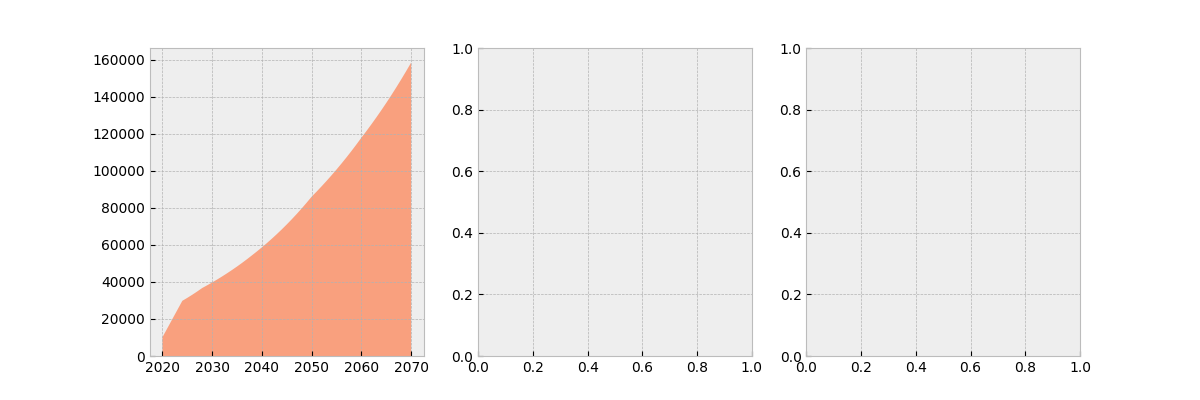

In [36]:
plot_stacked_evolution_subplots(lca_outputs)

In [ ]:
# Plot - Selection of Midpoints
df_to_plot = lca_outputs_df_scenario_1[
    ~lca_outputs_df_scenario_1.index.get_level_values('method').str.contains(
        'human health|ecosystem', case=False, na=False
    ) &
    lca_outputs_df_scenario_1.index.get_level_values('method').str.contains(
        'climate|land use|material', case=False, na=False
    )
]
plot_stacked_evolution_subplots(df_to_plot)
plt.savefig('lca_aeromaps_tsas_is0medium_midpoints_selection.pdf')

In [ ]:
# Plot - Endpoints
df_to_plot = lca_outputs_df_scenario_1[lca_outputs_df_scenario_1.index.get_level_values('method').str.contains('total')]  # endpoints
plot_stacked_evolution_subplots(df_to_plot)
plt.savefig('lca_aeromaps_tsas_is0medium_endpoints.pdf')

# Postprocessing - From midpoints to endpoints

In [ ]:
# Get all endpoints methods
methods = [m for m in agb.findMethods('', mainCat='ReCiPe 2016 v1.03, endpoint (H)') if 'total' not in m[1]]
methods_custom = [m for m in agb.findMethods('', mainCat='Custom methods') if 'total' not in m[1]]

methods_ecosystem = [m for m in methods + methods_custom if 'ecosystem quality' in m[1]]
methods_human_health = [m for m in methods + methods_custom if 'human health' in m[1]]
methods_resources = [m for m in methods + methods_custom if 'natural resources' in m[1]]

In [ ]:
# Remove duplicate methods (i.e. ReCiPe methods which are replaced by a custom method, if both are defined in the configuration file)
methods_dict = {'ecosystem quality': methods_ecosystem, 'human health': methods_human_health, 'natural resources': methods_resources}

for name, methods_list in methods_dict.items():
    methods_to_remove = []
    for m in methods_list:
        if m[0] == 'Custom methods':
            methods_to_remove.append(('ReCiPe 2016 v1.03, endpoint (H)', name, m[2]))
    methods_dict[name] = [m for m in methods_list if m not in methods_to_remove]

In [ ]:
# Add original LCIA methods for climate change to get difference involved by non-CO2
# This is more convenient than splitting the results by 'phase' but will require post-processing by hand
methods_dict['ecosystem quality'].append(('ReCiPe 2016 v1.03, endpoint (H)', 'ecosystem quality', 'climate change: freshwater ecosystems'))
methods_dict['ecosystem quality'].append(('ReCiPe 2016 v1.03, endpoint (H)', 'ecosystem quality', 'climate change: terrestrial ecosystems'))
methods_dict['human health'].append(('ReCiPe 2016 v1.03, endpoint (H)', 'human health', 'climate change: human health'))

In [ ]:
# Create function to get the data for each scenario
def get_scenario_data(scenario, year):
    scenario_data_vector = globals()[f'process_data_vector_outputs_scenario_{scenario}']
    #scenario_data_fleet = globals()[f'process_data_fleet_model_df_scenario_{scenario}']
    scenario_data_float = globals()[f'process_data_float_inputs_scenario_{scenario}']
    scenario_data_climate = globals()[f'process_data_climate_scenario_{scenario}']

    # !! Make sure all parameters are provided. If a parameter is missing, its default value (1.0) will be applied, so the results will be wrong !!
    params_dict = dict(
        model="remind",
        pathway="SSP2_Base",
        rpk_long_range=scenario_data_vector['rpk_long_range'][year],
        rpk_medium_range=scenario_data_vector['rpk_medium_range'][year],
        rpk_short_range=scenario_data_vector['rpk_short_range'][year],
        #aircraft_production_long_range=scenario_data_fleet['Long Range: Aircraft Production'][year],
        #aircraft_production_medium_range=scenario_data_fleet['Medium Range: Aircraft Production'][year],
        #aircraft_production_short_range=scenario_data_fleet['Short Range: Aircraft Production'][year],
        energy_consumption_kerosene=scenario_data_vector['energy_consumption_kerosene'][year],
        energy_consumption_biofuel=scenario_data_vector['energy_consumption_biofuel'][year],
        energy_consumption_electrofuel=scenario_data_vector['energy_consumption_electrofuel'][year],
        energy_consumption_hydrogen=scenario_data_vector['energy_consumption_hydrogen'][year],
        lhv_kerosene=scenario_data_float['lhv_kerosene'],
        lhv_biofuel=scenario_data_float['lhv_biofuel'],
        lhv_electrofuel=scenario_data_float['lhv_electrofuel'],
        lhv_hydrogen=scenario_data_float['lhv_hydrogen'],
        emission_index_nox_kerosene=scenario_data_vector['emission_index_nox_kerosene'][year],
        emission_index_sulfur_kerosene=scenario_data_float['emission_index_sulfur_kerosene'],
        #emission_index_h2o_kerosene=scenario_data_float['emission_index_h2o_kerosene'],
        emission_index_soot_kerosene=scenario_data_vector['emission_index_soot_kerosene'][year],
        emission_index_nox_biofuel=scenario_data_vector['emission_index_nox_biofuel'][year],
        emission_index_sulfur_biofuel=scenario_data_float['emission_index_sulfur_biofuel'],
        #emission_index_h2o_biofuel=scenario_data_float['emission_index_h2o_biofuel'],
        emission_index_soot_biofuel=scenario_data_vector['emission_index_soot_biofuel'][year],
        emission_index_nox_electrofuel=scenario_data_vector['emission_index_nox_electrofuel'][year],
        emission_index_sulfur_electrofuel=scenario_data_float['emission_index_sulfur_electrofuel'],
        #emission_index_h2o_electrofuel=scenario_data_float['emission_index_h2o_electrofuel'],
        emission_index_soot_electrofuel=scenario_data_vector['emission_index_soot_electrofuel'][year],
        emission_index_nox_hydrogen=scenario_data_vector['emission_index_nox_hydrogen'][year],
        total_aircraft_distance=scenario_data_climate['total_aircraft_distance'][year],
        fuel_effect_correction_contrails=scenario_data_vector['fuel_effect_correction_contrails'][year],
        #load_factor_photovoltaic=1.0,
        elec_solar_share=1.0,
        year=year
    )
    
    # Check if all parameters are provided
    missing_keys = set(agb.params.all_params().keys()) - set(params_dict.keys())
    extra_keys = set(agb.params.all_params().keys()) - set(params_dict.keys())
    
    # Raise errors for missing or extra keys
    if missing_keys:
        raise KeyError(f"Parameters are missing: {missing_keys}")
    if extra_keys:
        raise KeyError(f"Two many parameters: {extra_keys}")
    
    return params_dict

In [ ]:
# Settings
year=2050  # In what year
scenario_numbers = [1, 2, 3, 4]  # Which scenarios

# Initialize dictionaries to hold dataframes for each method
dfs = {}

for method_name, method in methods_dict.items():
    df = pd.DataFrame()
    for scenario in scenario_numbers:
        params_dict = get_scenario_data(scenario, year)

        res = agb.compute_impacts(
            process.models['life_cycle_assessment'].model,
            method,
            **params_dict,
        )

        # Rename the index for the current result
        res = res.rename(index={'model': f'scenario {scenario}'})
        
        # Concatenate the result to the DataFrame
        df = pd.concat([df, res], axis=0, ignore_index=False)
    
    # Normalize by the values of scenario 1
    #scenario_1_values = df.loc[df.index == 'scenario 1']
    #df = df.divide(scenario_1_values.values.sum())
    
    # Store the dataframe in the dictionary
    dfs[method_name] = df

In [ ]:
# Save to excel file
#for method_name in methods_dict.keys():
#    dfs[method_name].to_excel(f'tsas_endpoints_contributions_{method_name}.xlsx')

In [ ]:
# Modify the xlsx file at your wish for better plots, e.g. by merging low impact categories together and renaming the categories.

In [ ]:
# Reimport the data
dfs = {method_name: pd.read_excel(f'tsas_endpoints_contributions_{method_name}.xlsx', index_col=0) for method_name in methods_dict.keys()}
combined_df = pd.concat(dfs, names=['Method', 'Scenario'])#.reset_index()#(level=0)
combined_df

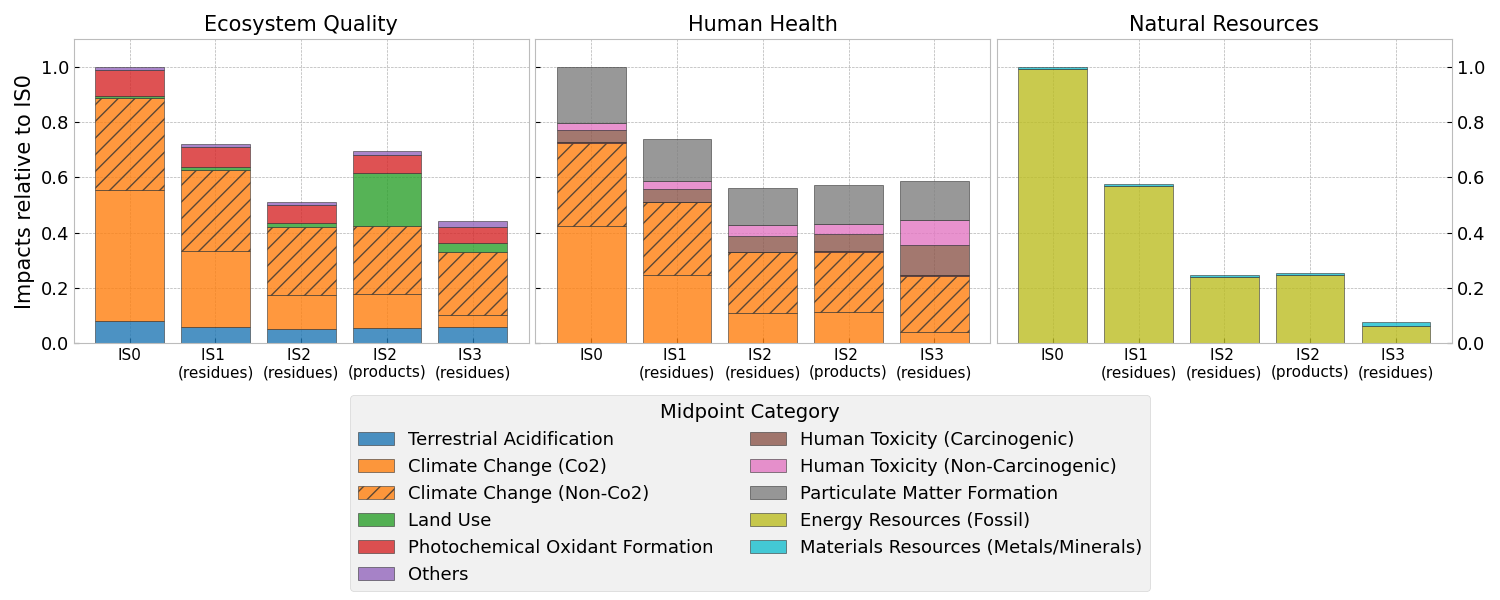

In [71]:
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec

# Set up three subplots (one for each endpoint)
clusters = combined_df.index.levels[0]  
inter_graph = 0
maxi = np.max(np.sum(combined_df, axis=1))
total_width = len(combined_df)+inter_graph*(len(clusters)-1)
fig = plt.figure(figsize=(total_width,6))

# Plot properties
gridspec.GridSpec(1, total_width)
axes=[]
palette = sns.color_palette("tab10")
palette.insert(1, palette[1])  # Duplicate color for second position (climate change CO2) for third position (climate change Non-CO2)
hatches = [''] * len(combined_df.index)
hatches[2] = '//'

ax_position = 0
for cluster in clusters:
    subset = combined_df.loc[cluster]
    ax = subset.plot(kind="bar", stacked=True, width=0.8, ax=plt.subplot2grid((1,total_width), (0,ax_position), colspan=len(subset.index)), color=palette, alpha=0.8, edgecolor='0.2')
    axes.append(ax)
    ax.set_title(cluster.title(), fontsize=15)
    ax.set_xlabel("")
    ax.set_ylim(0,maxi*1.1)
    #ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_position += len(subset.index)+inter_graph
    ax.tick_params(axis='x', rotation=0, labelsize=11)
    
    tick_labels = [label.get_text() for label in ax.get_xticklabels()]
    wrapped_labels = [
        '\n('.join([label.split('(')[0], label.split('(')[1]]) if '(' in label else label
        for label in tick_labels
    ]
    ax.set_xticklabels(wrapped_labels)
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    
    # Apply hatches to the specific segment of the stacks
    for bar_group, hatch_pattern in zip(ax.containers, hatches[:len(subset.columns)]):
        for bar in bar_group:
            bar.set_hatch(hatch_pattern)

for i in range(0,len(clusters)):
    axes[i].legend().set_visible(False)
for i in range(1,len(clusters)-1):
    axes[i].set_yticklabels("")
axes[-1].yaxis.tick_right()
axes[-1].tick_params(axis='y', labelsize=13)
axes[0].tick_params(axis='y', labelsize=13)
axes[0].set_ylabel("Impacts relative to IS0", fontsize=15)

# Collect legend labels from all plots.
entries = collections.OrderedDict()
for ax in axes:
    for handle, label in zip(*axes[0].get_legend_handles_labels()):
        label_name = label.replace('_', ' ').title()
        entries[label_name] = handle
legend = fig.legend(
    entries.values(), entries.keys(),
    loc='lower center', bbox_to_anchor=(0.5, 0),
    ncol=2,
    fontsize=13,
    title='Midpoint Category',
    title_fontsize=14
)

# Set tight layout while keeping legend in the screen
bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(fig.transFigure.inverted())
fig.tight_layout(rect=(0, bbox.y1, 1, 1), h_pad=0.5, w_pad=0.5)

plt.show()
plt.savefig('lca_aeromaps_tsas_endpoints_contributions.pdf')

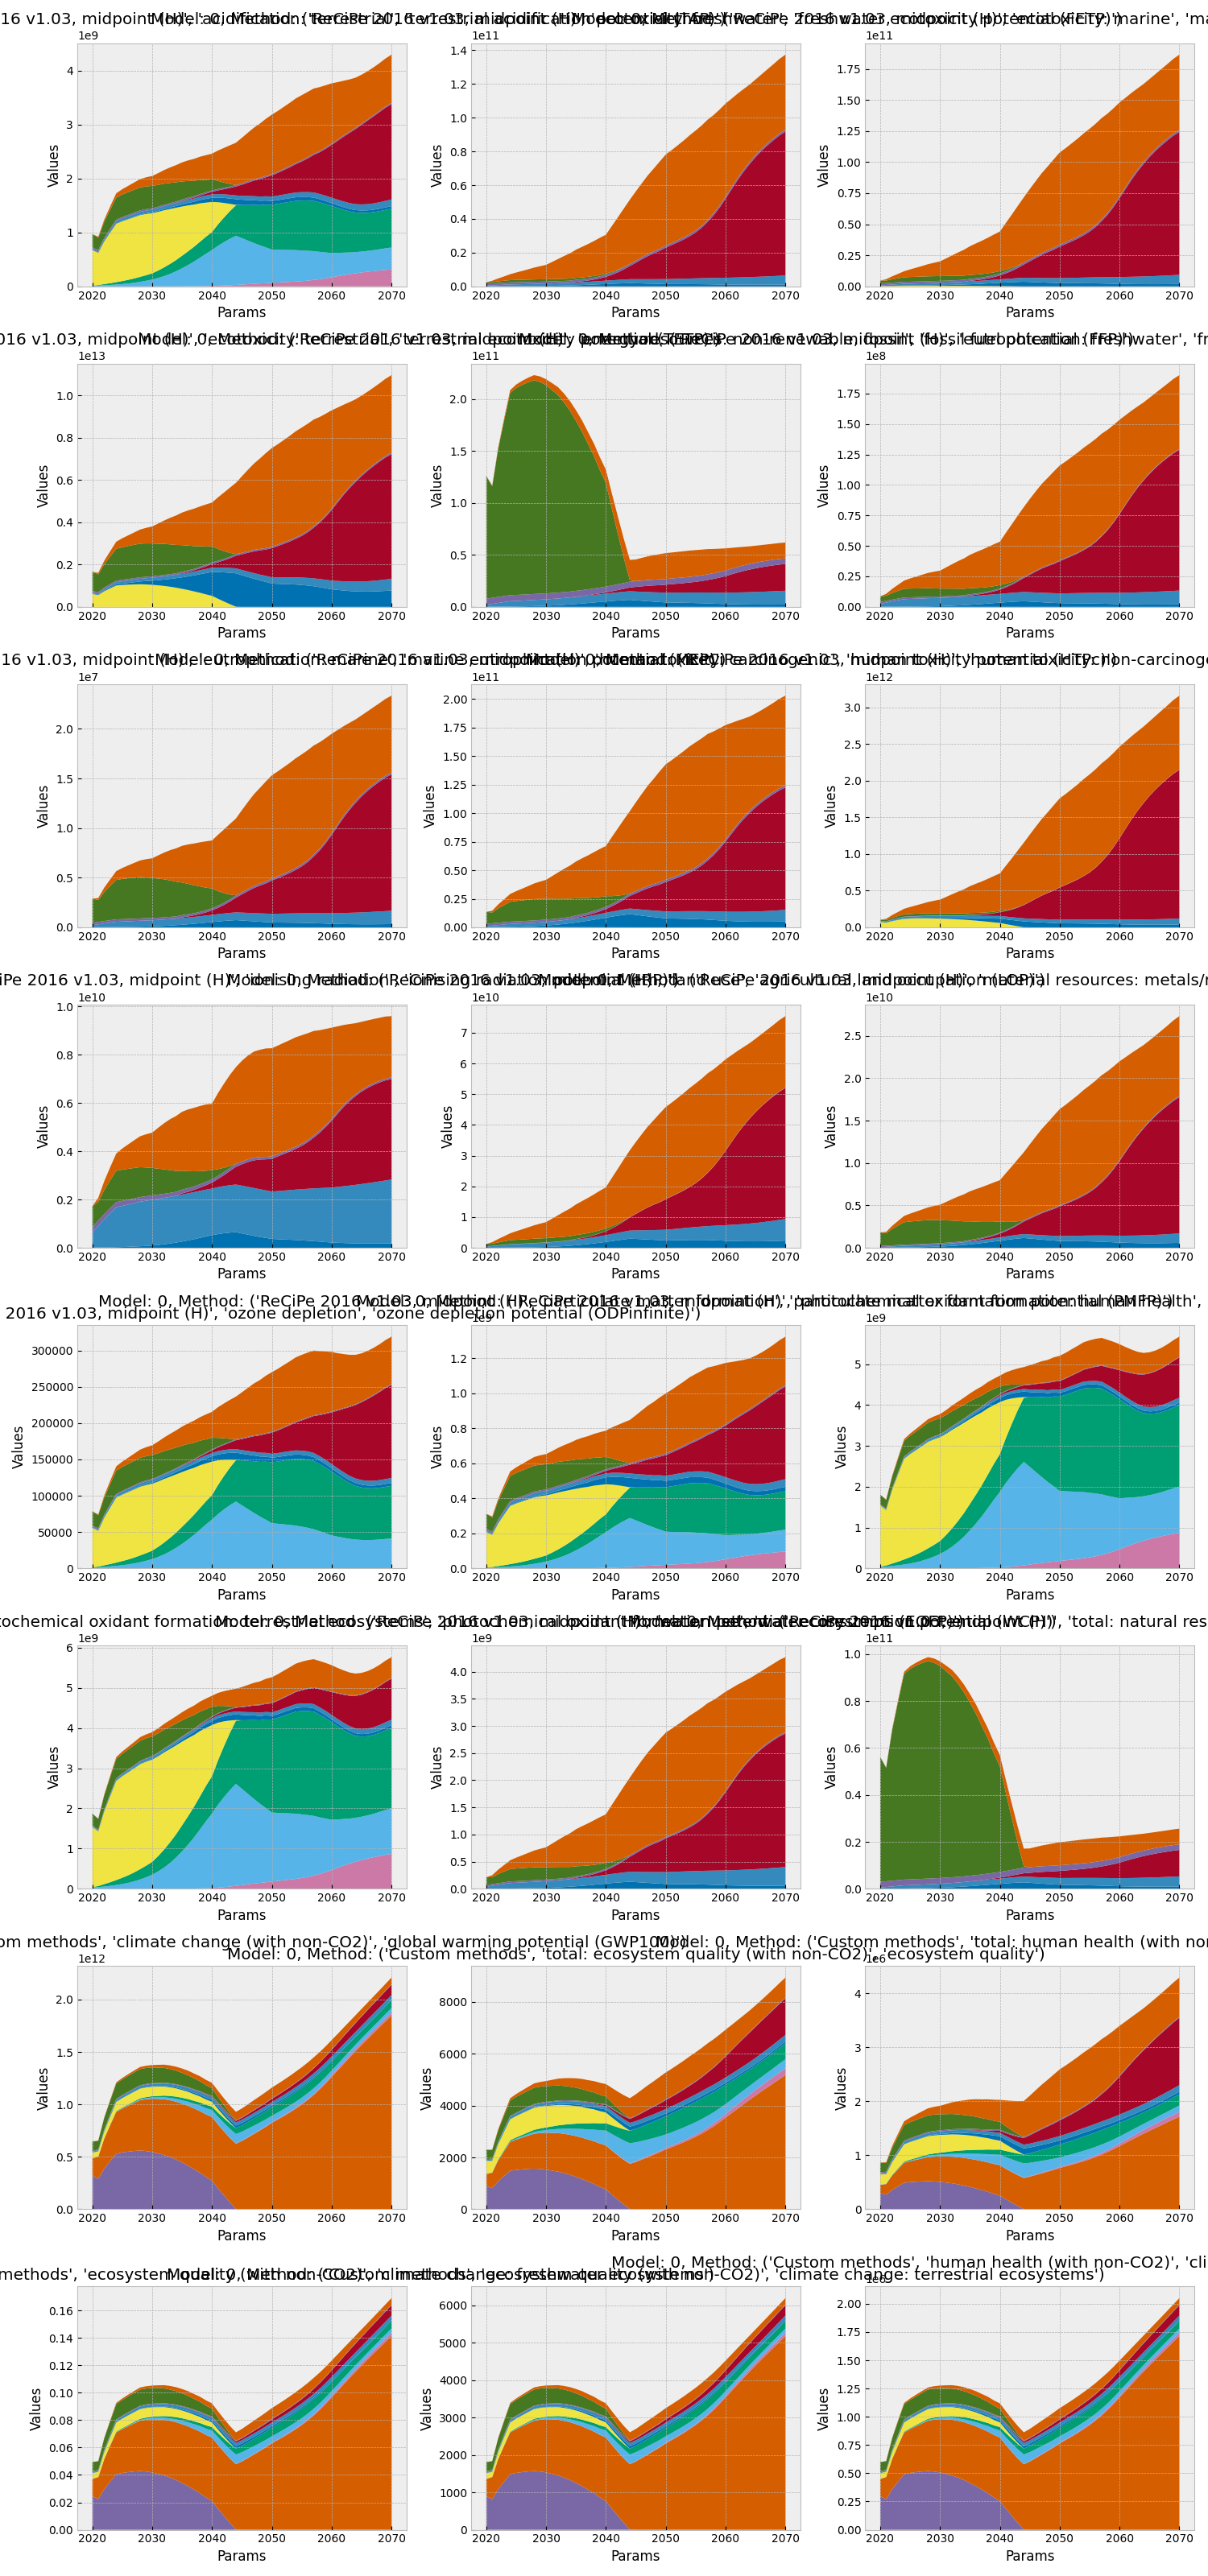

In [131]:
def plot_my_array(data_array):
    models = data_array.coords['system'].values
    methods = data_array.coords['impacts'].values
    params = data_array.coords['params'].values
    
    num_models = len(models)
    num_methods = len(methods)
    n_cols = 3 #2 if n_methods % 2 == 0 else 3
    n_rows = num_models * math.ceil(num_methods / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), squeeze=False)
    axes = axes.flatten() 
    
    for imodel, model in enumerate(models):
        for jmethod, method in enumerate(methods):
            ax = axes[imodel * num_methods + jmethod]
            ax.stackplot(params, data_array.isel(system=imodel, impacts=jmethod))
            #ax.plot(params, data_array.isel(model=imodel, method=jmethod))
            ax.set_title(f'Model: {imodel}, Method: {method}')
            ax.set_xlabel('Params')
            ax.set_ylabel('Values')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the data
plot_my_array(res)